In [22]:
import sys
sys.path.append('../..')
from TO.utils import check_package_status
check_package_status()

from experiments.utils import set_plt_template
set_plt_template()

<div class="alert alert-block alert-success" style="font-size: 14px; border-radius: 10px"><h4>[GO] TO @ 2507d7e13867b8bfb92d7b5cdd6aa92e6b27ca2c
</h4><pre>  ✅ No changes found in the ./TO packge.</pre></div>

In [115]:
from TO import Topology
from TO.parameterizations.mmc import StraightBeam, MMCAngularConfig, sample_equidistant_pts, Capsules, MMCCenterpointsConfig
from TO.problems.beam import create_horizontal_cantilever_problem
from TO.experiment import run_experiment

import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from shapely.geometry import Polygon, box

In [150]:
n_runs = 30
budget = 500
dimension = 10

results = {}
for exp in ('explicit-1mmc', 'relative-1mmc'):
    f = np.inf*np.ones((n_runs, budget))
    x_best = np.nan*np.ones((n_runs, parameterization_explicit_thickness.dimension))
    for i in range(n_runs):
        fmin = float('inf')
        try:
            with open(f'./results/{exp}/{i+1}/evals.dat', 'r') as handle : lines = handle.readlines()
            for j in range(budget) : 
                f[i,j] = lines[j].split()[1]
                if f[i,j] < fmin : 
                    fmin = f[i,j]
                    x_best[i] = list(map(float, lines[j].split()[2:]))
        except:
            continue
    results[exp] = (f, x_best)

(0.0, 0.5)

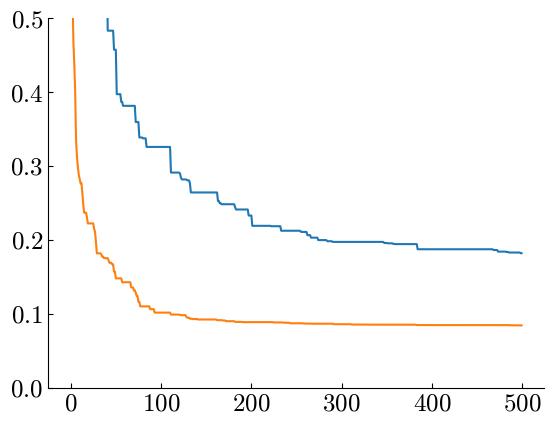

In [151]:
for (exp, (f, x_best)) in results.items():
    fmin = np.minimum.accumulate(f, axis=1)
    plt.plot(np.median(fmin, axis=0))
plt.ylim(0, 0.5)

In [152]:
n_runs = 30
budget = 500
dimension = 30

results = {}
for exp in ('explicit-3mmc', 'relative-3mmc'):
    f = np.inf*np.ones((n_runs, budget))
    x_best = np.nan*np.ones((n_runs, dimension))
    for i in range(n_runs):
        fmin = float('inf')
        try:
            with open(f'./results/{exp}/{i+1}/evals.dat', 'r') as handle : lines = handle.readlines()
            for j in range(budget) : 
                f[i,j] = lines[j].split()[1]
                if f[i,j] < fmin : 
                    fmin = f[i,j]
                    x_best[i] = list(map(float, lines[j].split()[2:]))
        except:
            continue
    results[exp] = (f, x_best)

(0.0, 0.5)

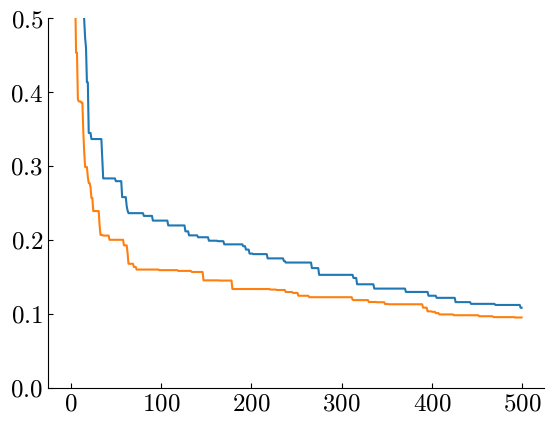

In [153]:
for (exp, (f, x_best)) in results.items():
    fmin = np.minimum.accumulate(f, axis=1)
    plt.plot(np.median(fmin, axis=0))
plt.ylim(0, 0.5)

In [154]:
class GuoBeamRelativeThickness(StraightBeam):
    dimension: int = 5

    def __init__(self, n_samples: int) : self.n_samples = n_samples

    def get_normalization_factors(self, topology: Topology, symmetry_x: bool, symmetry_y: bool) :
        self.rnorm = np.hypot(topology.domain_size_x, topology.domain_size_y)/2
        # we normalize r1 and r2 as it is -> 0-1 instead of rnorm
        return np.array([1, 1, self.rnorm/4, self.rnorm/4, 2*np.pi])

    def transform_pre_scale_y(self, geo: Polygon, config: MMCAngularConfig, x_scaled: np.ndarray):
        (r_left, r_right, a, b, phi) = x_scaled.flatten()
        (a, b, phi) = (a-self.rnorm/8, b-self.rnorm/8, phi-np.pi)

        # let's linearly map 0-1 to 0.25-4 * config.ry

        r_left = ((4 - 0.25)*r_left + 0.25) * config.ry
        r_right = ((4 - 0.25)*r_right + 0.25) * config.ry

        (x, y) = sample_equidistant_pts(np.c_[geo.exterior.xy], self.n_samples).T

        ry = (r_left + r_right - 2*config.ry) / 2 * (x/config.rx)**2 + (r_right - r_left)/2 * (x/config.rx) + config.ry
        f = a*np.sin(b*(x/config.rx + phi))
        y = (f + ry*y)/config.ry
        
        return Polygon(np.c_[x, y]).buffer(1e-2)

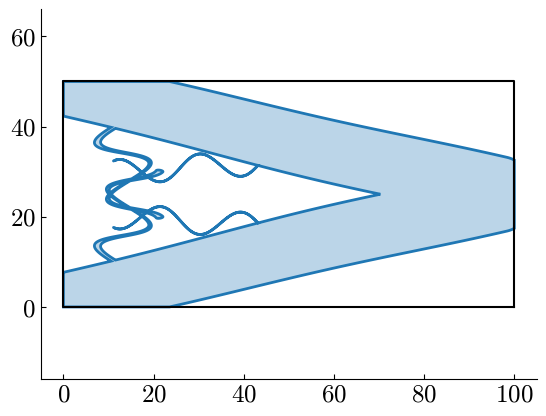

In [157]:
parameterization = Capsules(
    topology, 
    symmetry_x=False, 
    symmetry_y=True, 
    n_components=3, 
    n_samples=1000, 
    representation=MMCCenterpointsConfig, 
    transformer=GuoBeamRelativeThickness(n_samples=1000)
)

parameterization.update_topology(topology, x_best[fmin[:,-1].argmin()])
topology.plot()

In [159]:
x_best[fmin[:,-1].argmin()].reshape(-1, 10)[:,-3:]

array([[0.88166471, 0.10979979, 0.70756863],
       [0.47737744, 0.20558396, 0.29169339],
       [0.69918782, 0.00694541, 0.90337561]])